In [14]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tf_keras
import matplotlib.pyplot as plt

In [2]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

directorio = "brain_tumor_dataset"

imagenes = []
etiquetas = []

# Recorro el directorio y leo las imágenes
for categoria in os.listdir(directorio):
    ruta_categoria = os.path.join(directorio, categoria)
    for imagen_nombre in os.listdir(ruta_categoria):
        imagen_ruta = os.path.join(ruta_categoria, imagen_nombre)
        # Leo la imagen
        imagen = load_img(imagen_ruta, target_size=(224,224))
        imagen_array = img_to_array(imagen) / 255.0  # Normalizo la imagen
        imagenes.append(imagen_array)
        # Asigno la etiqueta (0 para "no" y 1 para "yes")
        etiquetas.append(1 if categoria == "yes" else 0)

# Convierto las listas en matrices numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

# Divido los datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(imagenes, etiquetas, test_size=0.3, random_state=42)

# Verifico las dimensiones de los conjuntos de datos
print("Dimensiones de X_entrenamiento:", X_entrenamiento.shape)
print("Dimensiones de X_prueba:", X_prueba.shape)
print("Dimensiones de y_entrenamiento:", y_entrenamiento.shape)
print("Dimensiones de y_prueba:", y_prueba.shape)

Dimensiones de X_entrenamiento: (463, 224, 224, 3)
Dimensiones de X_prueba: (199, 224, 224, 3)
Dimensiones de y_entrenamiento: (463,)
Dimensiones de y_prueba: (199,)


In [3]:
import tensorflow_hub as hub
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

movilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

movilenetv2.trainable = False

modelo = tf_keras.Sequential([
    movilenetv2,
    tf_keras.layers.Dense(2,activation="softmax")
])

In [4]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [9]:
modelo.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [10]:
entrenamiento = modelo.fit(
    X_entrenamiento,
    y_entrenamiento,
    epochs=20,
    validation_data = (X_prueba, y_prueba)
)

Epoch 1/20
15/15 [==============================] - 9s 454ms/step - loss: 0.1589 - accuracy: 0.9590 - val_loss: 0.2139 - val_accuracy: 0.9246
Epoch 2/20
15/15 [==============================] - 6s 379ms/step - loss: 0.1289 - accuracy: 0.9611 - val_loss: 0.1871 - val_accuracy: 0.9296
Epoch 3/20
15/15 [==============================] - 6s 444ms/step - loss: 0.1160 - accuracy: 0.9676 - val_loss: 0.1817 - val_accuracy: 0.9196
Epoch 4/20
15/15 [==============================] - 6s 438ms/step - loss: 0.1077 - accuracy: 0.9676 - val_loss: 0.1781 - val_accuracy: 0.9447
Epoch 5/20
15/15 [==============================] - 6s 435ms/step - loss: 0.0991 - accuracy: 0.9762 - val_loss: 0.1762 - val_accuracy: 0.9548
Epoch 6/20
15/15 [==============================] - 6s 440ms/step - loss: 0.0891 - accuracy: 0.9849 - val_loss: 0.1700 - val_accuracy: 0.9548
Epoch 7/20
15/15 [==============================] - 6s 415ms/step - loss: 0.0795 - accuracy: 0.9870 - val_loss: 0.1623 - val_accuracy: 0.9246
Epoch 

Found 20 images belonging to 2 classes.
1/1 [==============================] - 0s 217ms/step


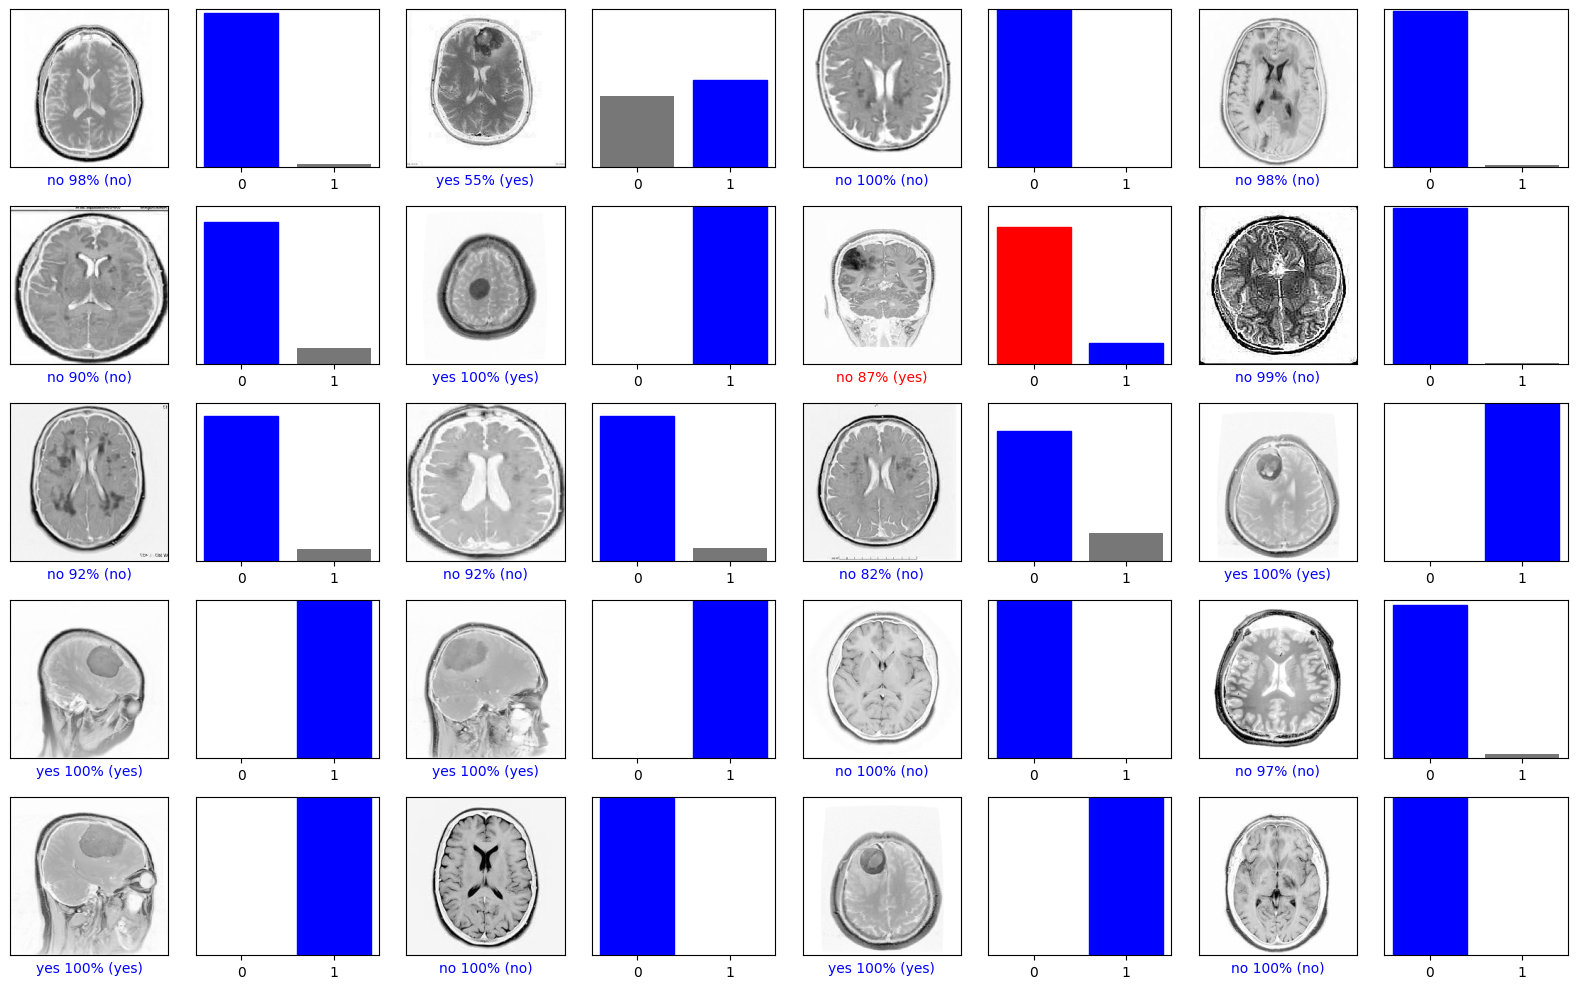

In [16]:
#GRAFICO ALGUNAS IMÁGENES PARA VER EL FUNCIONAMIENTO DEL MODELO GRÁFICAMENTE

datagen_testeo = ImageDataGenerator(rescale=1./255)

datos_testeo = datagen_testeo.flow_from_directory(
    "testing_dataset",
    target_size=(224,224),
    color_mode = "rgb",
    shuffle= True
)

nombres_clases=["no", "yes"]

# Obtengo las imagenes y sus etiquetas
imagenes_testeo, etiquetas_testeo = next(datos_testeo)
predicciones = modelo.predict(imagenes_testeo)

etiquetas_testeo = np.argmax(etiquetas_testeo, axis=1)

  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[..., 0], cmap=plt.cm.binary)
    
    etiqueta_prediccion = np.argmax(arr_predicciones)
    if etiqueta_prediccion == etiqueta_real:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                         100*np.max(arr_predicciones),
                                         nombres_clases[etiqueta_real]),
               color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    grafica = plt.bar(range(2), arr_predicciones, color="#777777")
    plt.ylim([0, 1]) 
    etiqueta_prediccion = np.argmax(arr_predicciones)
    
    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')


filas = 5
columnas = 4
num_imagenes = filas * columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_testeo, imagenes_testeo)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_testeo)

plt.tight_layout()
plt.show()